<h1 align="center">Maximum Likelihood Estimation</h1>

Imagine we have a biased coin with P(H) = $\theta$, P(T) = $1-\theta$. We've tossed this coin n times and come up with a sequence of coin tosses, D. D has $n_H$ heads and $n_T$ tails, with $n_H + n_T = n$. Furthermore, the coin tosses are IID. Under these conditions, the probability of getting exactly $n_H$ heads in $n$ tosses follows a Bernoulli distribution:

$P(Getting\ n_H\ heads\ in\ n\ tosses) = \theta^{n_H}(1-\theta)^{n_T}$.

We can describe the n coin tosses as a Probabilistic Graphical Model with a random variable $\theta$ and n instances of another random variable $X$, $(X[1], ...X[n])$, each instance representing one result of the coin toss.  Each $X[i]$ depends on $\theta$, but the coin tosses are independent of each other - i.e. any two $X[i]$ and $X[j]$ are independent of each other given $\theta$.


Populating the interactive namespace from numpy and matplotlib


{'A': <matplotlib.text.Text at 0x1dee8215a20>,
 'B': <matplotlib.text.Text at 0x1dee82153c8>,
 'C': <matplotlib.text.Text at 0x1dee8215f60>,
 'D': <matplotlib.text.Text at 0x1dee8215550>}

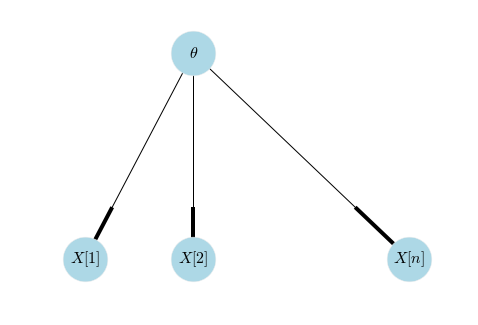

In [2]:
%pylab inline
pylab.style.use('ggplot')
import networkx as nx

G = nx.DiGraph()
G.add_edges_from([('A', 'B'), ('A', 'C'), ('A', 'D')])

pos = {'A': (2, 2), 'B': (1, 1), 'C': (2, 1), 'D':(4, 1)}

nx.draw(G, pos, node_size=2000, node_color='lightblue')

labels = {'A': '$\\theta$', 'B': '$X[1]$', 'C': '$X[2]$', 'D': '$X[n]$'}
nx.draw_networkx_labels(G,pos,labels,font_size=16)

Let each $X[i]$ take the value $x[i]$. Then $X[i]$ has the CPD:

$$P(x[i]|\theta) = \begin{cases}
\theta,\ if\ x[i]\ = 1&\\
1 - \theta,\ if\ x[i]\ = 0
\end{cases}$$

The goal of MLE is to find $\theta \in [0, 1]$ that predicts D well.

How can we measure the quality of our prediction for a given $\theta$? 

$L(\theta:D) = P(\theta|D) = \prod_{i=1}^n P(x[i]|\theta) = \theta^{n_H} (1-\theta)^{n_T}$.

It's much easier to differentiate over sums than products. We can convert the expression for L into a sum by taking its log:
$LL = Log(L)$. The log function is strictly monotonically increasing, so $argmax_\theta L(\theta) = argmax_\theta LL(\theta)$.

$LL(\theta) = n_H log(\theta) + n_T log(1-\theta)$. 

Let's plot the log-likelihood function for D = {H, T, T, H, H, T, T}, so that $n_H = 3$, $n_T = 4$ and finally $LL(\theta) = 3 log(\theta) + 4 log(1-\theta)$.

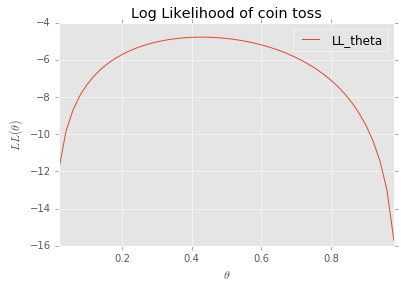

In [3]:
import pandas as pd
import numpy as np

theta = np.arange(0.02, 1, step=0.02)
LL_theta = 3 * np.log(theta) + 4 * np.log(1 - theta)
df = pd.DataFrame({'theta':theta, 'LL_theta':LL_theta})

ax = df.plot(kind='line', x='theta', y='LL_theta', title='Log Likelihood of coin toss')
ax.set(xlabel=r'$\theta$', ylabel=r'$LL(\theta)$')

Differentiating w.r.t $\theta$ gives us:

$\frac {d}{d\theta} [LL(\theta)] = \frac {n_H} {\theta} - \frac {n_T} {1-\theta}$

Setting $\frac {d}{d\theta} [LL(\theta)] = 0$, we get:

$\frac {n_H} {\theta} = \frac {n_T} {1-\theta} => \theta = \frac {n_H} {n_H + n_T}$

In this case, $n_H$ and $n_T$ completely describe the MLE expression. We call them the **Sufficient Statistics** for the coin toss dataset. We can think of the pair $(n_H, n_T)$ as a 'summary' of information contained in all possible instances of D. 

### Limitations of MLE

Imagine we have a competition where two teams play each other 10 times. Team A wins 7 times. MLE tells us that P(Team A wins) = 0.7. This seems somewhat plausible.

Now imagine we toss a coin 10 times (we don't know if the coin is biased or unbiased) and come up with heads 7 times. MLE again tells us that P(head) = 0.7. This may or may not be plausible.


Now imagine we toss the same coin 10,000 times and come up with heads 7000 times. MLE again tells us that P(head) = 0.7. This sounds a lot more plausible.

One limitation of MLE is that it cannot distinguish between these 3 cases.

## Expectation Maximization as Iterative MLE

For the majority of real world cases, the likelihood function is not concave, e.g. in HMM and GMMs. In such a scenario, one typically encounters a constrained optimization problem with multiple local maxima. Expectation maximization is a special purpose iterative technique designed for MLE. 

### Intution Behind EM

* Parameter estimation is easy when we have complete data (e.g. there weren't any latent variables).
* Computing probabilities of latent variables (inference) is easy if we knew what the true value of the parameter(s) was (were).

### EM Overview

1. 'Guess' initial parameters.

2. Iterate until convergence:

    - **E-step**: Complete the probabilities of the missing variables.
    - **M-step**: Re-estimate the parameters by solving the simpler MLE problem.   
  

### A Coin Toss Example <a href="http://ai.stanford.edu/~chuongdo/papers/em_tutorial.pdf">(Do and Batzoglou)</a>

Imagine that we now have two biased coins, A and B, with $P(H) = \theta_A$ and $P(H) = \theta_B$. We now conduct a number of experiments. In each turn, we pick either coin A or coin B and flip it 10 times. The tosses in each turn are still IID, but we don't know which coin we're using. We can express each turn as a PGM:

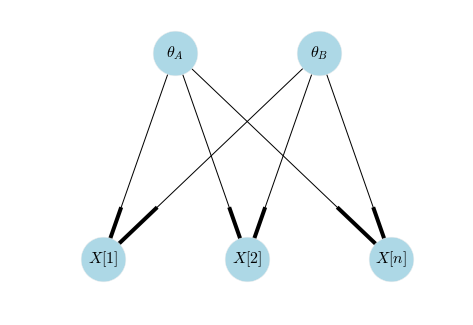

In [4]:
G = nx.DiGraph()
G.add_edges_from([
    ('A', 'X'), ('A', 'Y'), ('A', 'Z'), 
    ('B', 'X'), ('B', 'Y'), ('B', 'Z')
])

pos = {'A': (2, 2), 'B': (4, 2), 
       'X': (1, 1), 'Y':(3, 1), 'Z':(5, 1)}

nx.draw(G, pos, node_size=2000, node_color='lightblue')

labels = {'A': r'$\theta_A$', 'B': r'$\theta_B$', 
          'X': '$X[1]$', 'Y': '$X[2]$', 'Z': '$X[n]$'}

nodes = nx.draw_networkx_labels(G,pos,labels,font_size=16)

In [5]:
import pandas as pd

experiments = pd.DataFrame([
        'H H H H T H H H H H'.split(' '),
        'H T T T H H T H T H'.split(' '),        
        'T H H H T H H H T H'.split(' '),
        'H T H T T T H H T T'.split(' '),
        'H H T T H H H T H H'.split(' '),
    ])

experiments

,0,1,2,3,4,5,6,7,8,9
0,H,H,H,H,T,H,H,H,H,H
1,H,T,T,T,H,H,T,H,T,H
2,T,H,H,H,T,H,H,H,T,H
3,H,T,H,T,T,T,H,H,T,T
4,H,H,T,T,H,H,H,T,H,H


In [6]:
# count Heads and tails in each turn
ht_counts = experiments.apply(lambda row: row.value_counts(), axis=1)
ht_counts.T

,0,1,2,3,4
H,9,5,7,4,7
T,1,5,3,6,3


In [7]:
theta = np.array([0.6, 0.5])

def log_likelihoods(t):
    # Calculates log likelihoods for theta_A and theta_B.
    # For turn 0, the likelihoods are:
    # L(theta_A) = t[0]^9 + (1-t[0])^1
    # L(theta_B) = t[1]^9 + (1-t[1])^1
    
    lls = []
    for t_i in t:
        r = ht_counts.dot([np.log(t_i), np.log(1-t_i)])
        lls.append(r)
        
    lls = pd.concat(lls, axis=1, keys=['Coin=A', 'Coin=B'])
    return lls

def norm_probs(ll_row):
    # Calculates [P(coin=A), P(coin=B)] from [ll(coin=A), ll(coin=B)] for each row
    s = np.exp(ll_row)
    return s / np.sum(s)

def e_step(step_num, t):
    lls = log_likelihoods(t)
    
    if step_num == 1:
        print('Log-likelihood for theta:\n', lls)
    probs = lls.apply(norm_probs, axis=1)
    
    if step_num == 1:
        print('Normalized probs:\n', probs)
        
    
    expectations = []
    
    for coin in probs.keys():
        hts_expected = ht_counts.mul(probs[coin].values, axis=0)
        expectations.append(hts_expected)
        if step_num == 1:
            print('Expected Heads and Tails assuming %s' % coin)        
            print(hts_expected)
            
    return expectations
                 
def m_step(exps):
    new_t = np.array([e['H'].sum() / e.values.sum() for e in exps])
    return new_t

def em(theta, steps=50):
    t = theta
    
    for i in range(1, steps+1):
        expectations = e_step(i, t)
        new_t = m_step(expectations)
        
        if i % 10 == 0:
            print('Changes in theta for step %s: %s' % (i, new_t-t))            
        t = new_t
        
em(theta=theta)

Log-likelihood for theta:
      Coin=A    Coin=B
0 -5.513721 -6.931472
1 -7.135582 -6.931472
2 -6.324652 -6.931472
3 -7.541047 -6.931472
4 -6.324652 -6.931472
Normalized probs:
      Coin=A    Coin=B
0  0.804986  0.195014
1  0.449149  0.550851
2  0.647215  0.352785
3  0.352156  0.647844
4  0.647215  0.352785
Expected Heads and Tails assuming Coin=A
          H         T
0  7.244870  0.804986
1  2.245745  2.245745
2  4.530506  1.941645
3  1.408625  2.112937
4  4.530506  1.941645
Expected Heads and Tails assuming Coin=B
          H         T
0  1.755130  0.195014
1  2.754255  2.754255
2  2.469494  1.058355
3  2.591375  3.887063
4  2.469494  1.058355
Changes in theta for step 10: [ 0.00063746 -0.00049373]
Changes in theta for step 20: [  2.16858468e-06  -1.58666658e-06]
Changes in theta for step 30: [  7.03312519e-09  -5.14270526e-09]
Changes in theta for step 40: [  2.28033148e-11  -1.66739955e-11]
Changes in theta for step 50: [  7.38298311e-14  -5.41788836e-14]
